Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    10000 non-null  object 
 1   symbol  10000 non-null  object 
 2   open    10000 non-null  float64
 3   close   10000 non-null  float64
 4   low     10000 non-null  float64
 5   high    10000 non-null  float64
 6   volume  10000 non-null  float64
dtypes: float64(5), object(2)
memory usage: 547.0+ KB
None

Descriptive Statistics:
               open         close           low          high        volume
count  10000.000000  10000.000000  10000.000000  10000.000000  1.000000e+04
mean      48.188768     48.126816     47.536590     48.717662  7.706110e+06
std       49.882865     49.680662     49.132276     50.312220  1.955800e+07
min        1.380000      1.370000      1.360000      1.410000  0.000000e+00
25%       24.677499     24.670000     24.340000     25.017500  1.473875e+06
50% 

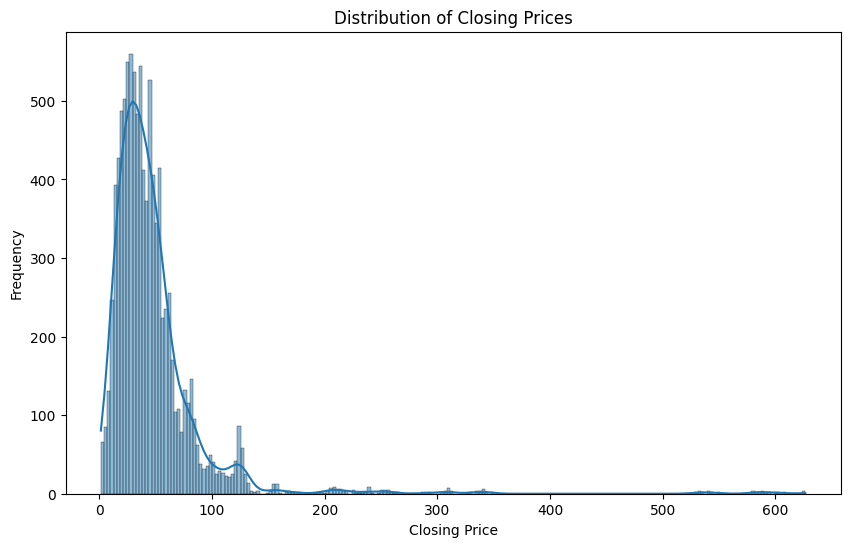

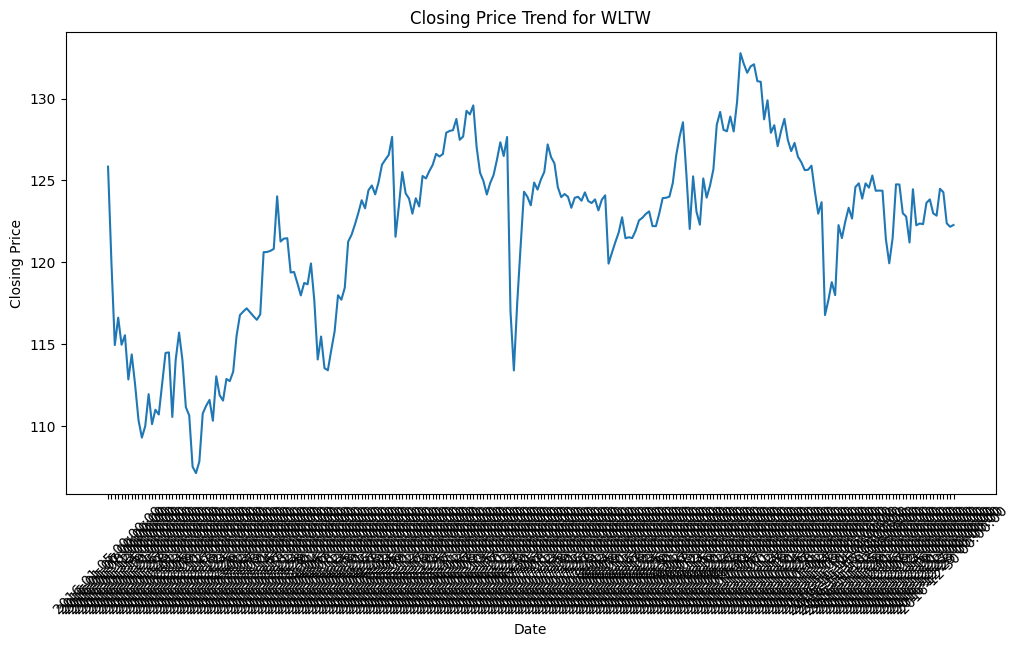

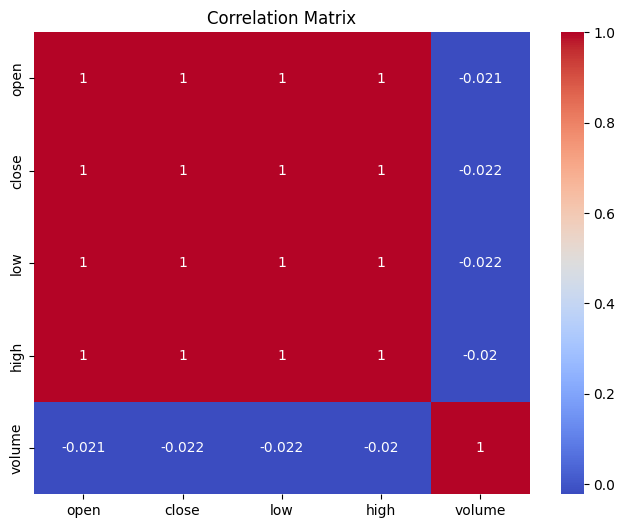


First 5 rows of the dataframe:
                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (using a smaller subset for demonstration)
try:
    df = pd.read_csv("prices.csv", nrows=10000)  # Adjust nrows as needed
except FileNotFoundError:
    print("Error: 'prices.csv' not found.  Make sure the file is in the correct directory, or specify the full path.")
    exit()


# Basic information
print("Dataframe Info:")
print(df.info())

# Summary statistics
print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Visualize the distribution of the 'close' price
plt.figure(figsize=(10, 6))
sns.histplot(df['close'], kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

# Visualize 'close' price over time for a specific stock (e.g., the first stock)
first_stock = df['symbol'].iloc[0]
stock_data = df[df['symbol'] == first_stock].sort_values(by='date')

plt.figure(figsize=(12, 6))
plt.plot(stock_data['date'], stock_data['close'])
plt.title(f'Closing Price Trend for {first_stock}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.show()

# Correlation matrix (numerical features only)
numerical_df = df[['open', 'close', 'low', 'high', 'volume']]
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Display the first few rows of the DataFrame
print("\nFirst 5 rows of the dataframe:")
print(df.head())

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Define a custom dataset class
class StockDataset(Dataset):
    def __init__(self, dataframe, features, target):
        self.features = torch.tensor(dataframe[features].values, dtype=torch.float32)
        self.target = torch.tensor(dataframe[target].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# Define the DNN model
class StockDNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(StockDNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, 1)  # Output layer for regression

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        return x

# Load data (using the same subset as before)
try:
    df = pd.read_csv("prices.csv", nrows=10000) # Adjust nrows as needed
except FileNotFoundError:
    print("Error: 'prices.csv' not found.  Make sure the file is in the correct directory, or specify the full path.")
    exit()

# Prepare data
features = ['open', 'low', 'high', 'volume']
target = 'close'  # Define the target variable *before* one-hot encoding


# Handle categorical variable 'symbol' using one-hot encoding
df = pd.get_dummies(df, columns=['symbol']) # One-hot encode the 'symbol' column

# Ensure 'close' is present when defining the features
features = ['open', 'low', 'high', 'volume'] + [col for col in df.columns if col.startswith('symbol_')]

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors and create DataLoaders
# Create DataFrames *before* scaling, then scale the *values* within the DataFrame

train_df = pd.DataFrame(X_train, columns=features)
train_df['close'] = y_train.values  # Add the 'close' column back

test_df = pd.DataFrame(X_test, columns=features)
test_df['close'] = y_test.values # Add the 'close' column back


train_dataset = StockDataset(train_df, features, target)
test_dataset = StockDataset(test_df, features, target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Instantiate the model
input_size = len(features)
hidden_size1 = 64
hidden_size2 = 32
model = StockDNN(input_size, hidden_size1, hidden_size2)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified for brevity - see question 4 for a more complete example)
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Finished Training")

Epoch [1/10], Loss: 117.2810
Epoch [2/10], Loss: 2.4591
Epoch [3/10], Loss: 1.1733
Epoch [4/10], Loss: 4.6307
Epoch [5/10], Loss: 1.8745
Epoch [6/10], Loss: 1.5380
Epoch [7/10], Loss: 5.8111
Epoch [8/10], Loss: 5.8597
Epoch [9/10], Loss: 3.8082
Epoch [10/10], Loss: 2.3346
Finished Training


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import ParameterGrid
import numpy as np


# Define a custom dataset class
class StockDataset(Dataset):
    def __init__(self, dataframe, features, target):
        self.features = torch.tensor(dataframe[features].values, dtype=torch.float32)
        self.target = torch.tensor(dataframe[target].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# Define the DNN model
class StockDNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(StockDNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, 1)  # Output layer for regression

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        return x

# Load data (using the same subset as before)
try:
    df = pd.read_csv("prices.csv", nrows=10000) # Adjust nrows as needed
except FileNotFoundError:
    print("Error: 'prices.csv' not found.  Make sure the file is in the correct directory, or specify the full path.")
    exit()

# Prepare data
features = ['open', 'low', 'high', 'volume']
target = 'close'


# Handle categorical variable 'symbol' using one-hot encoding
df = pd.get_dummies(df, columns=['symbol']) # One-hot encode the 'symbol' column

# Ensure 'close' is present when defining the features
features = ['open', 'low', 'high', 'volume'] + [col for col in df.columns if col.startswith('symbol_')]

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors and create DataLoaders
# Create DataFrames *before* scaling, then scale the *values* within the DataFrame
train_df = pd.DataFrame(X_train, columns=features)
train_df['close'] = y_train.values  # Add the 'close' column back

test_df = pd.DataFrame(X_test, columns=features)
test_df['close'] = y_test.values # Add the 'close' column back

train_dataset = StockDataset(train_df, features, target)
test_dataset = StockDataset(test_df, features, target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Define the hyperparameter grid
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'optimizer': ['Adam', 'SGD'],
    'hidden_size1': [32, 64],
    'hidden_size2': [16, 32],
    'epochs': [5, 10]
}

# Grid Search Function
def train_and_evaluate(params):
    # Model instantiation
    model = StockDNN(len(features), params['hidden_size1'], params['hidden_size2'])

    # Optimizer selection
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=params['lr'])

    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(params['epochs']):
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation on test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0) # Accumulate the loss

    test_loss = test_loss / len(test_loader.dataset) # Calculate mean test loss

    return test_loss

# Perform Grid Search
best_loss = float('inf')
best_params = None

grid = ParameterGrid(param_grid)

for params in grid:
    print(f"Training with parameters: {params}")
    test_loss = train_and_evaluate(params)
    print(f"Test Loss: {test_loss:.4f}")

    if test_loss < best_loss:
        best_loss = test_loss
        best_params = params

print(f"Best parameters: {best_params}")
print(f"Best Test Loss: {best_loss:.4f}")

Training with parameters: {'epochs': 5, 'hidden_size1': 32, 'hidden_size2': 16, 'lr': 0.001, 'optimizer': 'Adam'}
Test Loss: 2.8733
Training with parameters: {'epochs': 5, 'hidden_size1': 32, 'hidden_size2': 16, 'lr': 0.001, 'optimizer': 'SGD'}
Test Loss: 1855.6167
Training with parameters: {'epochs': 5, 'hidden_size1': 32, 'hidden_size2': 16, 'lr': 0.01, 'optimizer': 'Adam'}
Test Loss: 30.6133
Training with parameters: {'epochs': 5, 'hidden_size1': 32, 'hidden_size2': 16, 'lr': 0.01, 'optimizer': 'SGD'}
Test Loss: nan
Training with parameters: {'epochs': 5, 'hidden_size1': 32, 'hidden_size2': 16, 'lr': 0.1, 'optimizer': 'Adam'}
Test Loss: 13.8638
Training with parameters: {'epochs': 5, 'hidden_size1': 32, 'hidden_size2': 16, 'lr': 0.1, 'optimizer': 'SGD'}
Test Loss: nan
Training with parameters: {'epochs': 5, 'hidden_size1': 32, 'hidden_size2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Test Loss: 3.1228
Training with parameters: {'epochs': 5, 'hidden_size1': 32, 'hidden_size2': 32, 'lr': 

Epoch [1/50], Train Loss (Original): 2110.0773, Test Loss (Original): 168.2234
Epoch [2/50], Train Loss (Original): 37.8615, Test Loss (Original): 3.9571
Epoch [3/50], Train Loss (Original): 3.1709, Test Loss (Original): 2.8974
Epoch [4/50], Train Loss (Original): 2.9516, Test Loss (Original): 2.9831
Epoch [5/50], Train Loss (Original): 3.1251, Test Loss (Original): 3.3340
Epoch [6/50], Train Loss (Original): 3.4143, Test Loss (Original): 4.0431
Epoch [7/50], Train Loss (Original): 3.8026, Test Loss (Original): 4.0082
Epoch [8/50], Train Loss (Original): 3.7350, Test Loss (Original): 4.1650
Epoch [9/50], Train Loss (Original): 3.8352, Test Loss (Original): 3.9123
Epoch [10/50], Train Loss (Original): 4.0389, Test Loss (Original): 4.1695
Epoch [11/50], Train Loss (Original): 4.3926, Test Loss (Original): 5.1146
Epoch [12/50], Train Loss (Original): 4.3084, Test Loss (Original): 4.4477
Epoch [13/50], Train Loss (Original): 4.2848, Test Loss (Original): 4.3954
Epoch [14/50], Train Loss (O

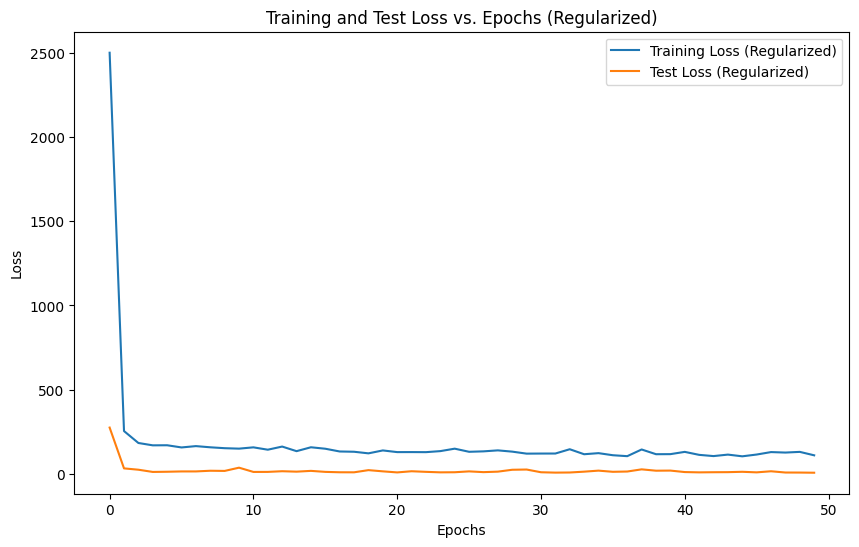

R-squared Training (Regularized): 0.9968740188702815
R-squared Testing (Regularized): 0.9955057707858302


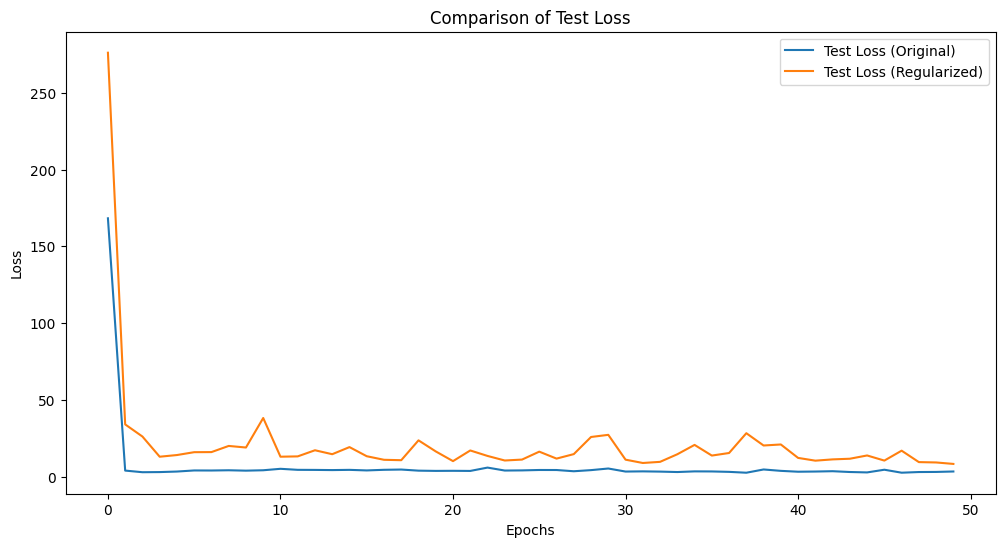

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

# Define a custom dataset class
class StockDataset(Dataset):
    def __init__(self, dataframe, features, target):
        self.features = torch.tensor(dataframe[features].values, dtype=torch.float32)
        self.target = torch.tensor(dataframe[target].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# Define the DNN model with L2 Regularization (Weight Decay) and Dropout
class StockDNNRegularized(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_rate=0.5):
        super(StockDNNRegularized, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer

        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer

        self.layer3 = nn.Linear(hidden_size2, 1)  # Output layer for regression

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        return x

# Define the DNN model
class StockDNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(StockDNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, 1)  # Output layer for regression

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        return x


# Load data (using the same subset as before)
try:
    df = pd.read_csv("prices.csv", nrows=10000) # Adjust nrows as needed
except FileNotFoundError:
    print("Error: 'prices.csv' not found.  Make sure the file is in the correct directory, or specify the full path.")
    exit()

# Prepare data
features = ['open', 'low', 'high', 'volume']
target = 'close'

# Handle categorical variable 'symbol' using one-hot encoding
df = pd.get_dummies(df, columns=['symbol']) # One-hot encode the 'symbol' column
features = ['open', 'low', 'high', 'volume'] + [col for col in df.columns if col.startswith('symbol_')]

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors and create DataLoaders
# Create DataFrames *before* scaling, then scale the *values* within the DataFrame
train_df = pd.DataFrame(X_train, columns=features)
train_df['close'] = y_train.values  # Add the 'close' column back

test_df = pd.DataFrame(X_test, columns=features)
test_df['close'] = y_test.values # Add the 'close' column back

train_dataset = StockDataset(train_df, features, target)
test_dataset = StockDataset(test_df, features, target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Instantiate the original model
input_size = len(features)
hidden_size1 = 64
hidden_size2 = 32
model = StockDNN(input_size, hidden_size1, hidden_size2) # Original model

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with loss tracking for the original model
num_epochs = 50
train_losses = []  # Initialize train_losses
test_losses = []   # Initialize test_losses

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Testing
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss (Original): {train_loss:.4f}, Test Loss (Original): {test_loss:.4f}')

# Instantiate the regularized model
input_size = len(features)
hidden_size1 = 64
hidden_size2 = 32
dropout_rate = 0.3
model_reg = StockDNNRegularized(input_size, hidden_size1, hidden_size2, dropout_rate)

# Define loss function and optimizer (with weight decay for L2 regularization)
criterion = nn.MSELoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Training loop with loss tracking for the regularized model
train_losses_reg = []
test_losses_reg = []

for epoch in range(num_epochs):
    # Training
    model_reg.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_reg(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer_reg.zero_grad()
        loss.backward()
        optimizer_reg.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_losses_reg.append(train_loss)

    # Testing
    model_reg.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model_reg(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    test_losses_reg.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss (Regularized): {train_loss:.4f}, Test Loss (Regularized): {test_loss:.4f}')

# Plotting Loss for the regularized model
plt.figure(figsize=(10, 6))
plt.plot(train_losses_reg, label='Training Loss (Regularized)')
plt.plot(test_losses_reg, label='Test Loss (Regularized)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs. Epochs (Regularized)')
plt.legend()
plt.show()

# Evaluate R-squared for the regularized model

from sklearn.metrics import r2_score

model_reg.eval()

with torch.no_grad():
    train_preds = []
    train_labels = []
    for inputs, labels in train_loader:
        outputs = model_reg(inputs)
        train_preds.extend(outputs.numpy().flatten())
        train_labels.extend(labels.numpy().flatten())

    r2_train_reg = r2_score(train_labels, train_preds)

    test_preds = []
    test_labels = []

    for inputs, labels in test_loader:
        outputs = model_reg(inputs)
        test_preds.extend(outputs.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())

    r2_test_reg = r2_score(test_labels, test_preds)

print(f"R-squared Training (Regularized): {r2_train_reg}")
print(f"R-squared Testing (Regularized): {r2_test_reg}")

# Comparaison (visual)
plt.figure(figsize=(12, 6))
plt.plot(test_losses, label='Test Loss (Original)')
plt.plot(test_losses_reg, label='Test Loss (Regularized)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Test Loss')
plt.legend()
plt.show()